# Metrix Evaluation

## Information to run the notebook 

To run the notebook follow the steps:
1. clone the repository on you device
2. open each notebook on [Google Colab](https://research.google.com/colaboratory/)
3. copy on your [Drive google](https://drive.google.com/drive/my-drive) the following directory (The directories must be collocated under the directory "MyDrive"):
  - dataset
  - configuration_file_SUS_project 

Then you are able to run each notebook without problem.

# Run the notebook on custom dataset

In order to run the notebook on custom dataset you need to organize the configuration directory in the following way:

```
dataset
└─── original dataset
|   |
|   └─── images
|   |   |
|   |   └─── test_dir
|   |   └─── train_dir
|   |   └─── val_dir
|   |
|   |
|   └─── labels
|   |   |
|   |   └─── test_dir
|   |   └─── train_dir
|   |   └─── val_dir

```

Under images each directory contains all the images used as training, validation and test sets.
Under labels each directory contains the labels for each image. \\
The image and its labels must have the same name.

### Support Function

In [1]:
def convert_annotations_to_df(ANNOT_PATH, IMAGE_PATH):
  #define the category dict
  cat_dict = {1 :"tank", 2:"car", 3:"truck",  4:"boat", 5:"airplane", 6:"horse trailer", 7:"train", 8:"motorcycle" ,  9:"Unknow"}

  f = open(ANNOT_PATH)
  json_ = json.load(f)
  df_images = pd.DataFrame.from_dict(json_["images"])
  df_annotations = pd.DataFrame.from_dict(json_["annotations"])

  # create dataframe with the bounding box information
  dt = {}
  for index, row in df_annotations.iterrows():
    dt[index] = row["bbox"]
  df = pd.DataFrame.from_dict(dt, orient="index")
  # the column represent = 0:left, 1:top, 2:width, 3:height
  # I do the transformation as= 0:x_min, 1:y_min, 2:x_max, 3:y_max
  df.rename(columns = {0:"xmin", 1:"ymin", 2:"xmax", 3:"ymax"}, inplace= True)

  #merge the two dataframe
  df_annotations = pd.merge(df_annotations, df, left_index=True, right_index=True)
  df_annotations.drop(["area", "segmentation" , "iscrowd", "bbox", "id"], axis = 1, inplace = True)

  #add the category labels information
  df_annotations["class"] = df_annotations.apply(lambda row: cat_dict[row["category_id"]], axis=1)

  #join the images based on the id column
  #df_images = pd.merge(df_annotations, df_images, left_index=True, right_index=True)
  df_images = pd.merge(df_annotations, df_images, left_on="image_id", right_on="id")
  
  #change the filename information to contain the correct directory
  dt = {}
  for index, row in df_images.iterrows():
    dt[index] = f"{IMAGE_PATH}{row['file_name']}"
  df = pd.DataFrame.from_dict(dt, orient="index")
  df_images = pd.merge(df_images, df, left_index=True, right_index=True)


  df_images.drop(["image_id", "id", "file_name"], axis = 1, inplace=True)
  #modify some column
  df_images.rename(columns = {0:"filename", "category_id":"labels"}, inplace=True)

  return df_images   

## Load the dataset

In [2]:
#Update sys path to include the pytorch RetinaNet modules
import warnings
import os
import sys
import json
import pandas as pd
import json
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, metrics

import pandas as pd
from PIL import Image
import cv2
import numpy as np

In [3]:
#connect to google drive and get the  dataset
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
#Path to where the Images are stored
TRAIN_IMAGE_PATH = "/content/train/"
VALID_IMAGE_PATH = "/content/valid/"
TEST_IMAGE_PATH  = "/content/test/"

train_annotations_json_file = "/content/gdrive/MyDrive/configuration_file_SUS_project/YOLOX/train2017.json"
test_annotations_json_file = "/content/gdrive/MyDrive/configuration_file_SUS_project/YOLOX/test2017.json"
val_annotations_json_file = "/content/gdrive/MyDrive/configuration_file_SUS_project/YOLOX/val2017.json"

#convert JSON files to pandas DataFrames
train_df = convert_annotations_to_df(train_annotations_json_file,TRAIN_IMAGE_PATH  )
valid_df = convert_annotations_to_df(val_annotations_json_file, VALID_IMAGE_PATH)
test_df  = convert_annotations_to_df(test_annotations_json_file, TEST_IMAGE_PATH )


In [5]:
def remove_invalid_annots(df):
    """
    Removes annotations where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
train_df = remove_invalid_annots(train_df)
valid_df = remove_invalid_annots(valid_df)
test_df  = remove_invalid_annots(test_df)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   labels    611 non-null    int64  
 1   xmin      611 non-null    float64
 2   ymin      611 non-null    float64
 3   xmax      611 non-null    float64
 4   ymax      611 non-null    float64
 5   class     611 non-null    object 
 6   height    611 non-null    int64  
 7   width     611 non-null    int64  
 8   filename  611 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 43.1+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   labels    253 non-null    int64  
 1   xmin      253 non-null    float64
 2   ymin      253 non-null    float64
 3   xmax      253 non-null    float64
 4   ymax      253 non-null    float64
 5   class     253 non-null    object 
 6   height    253 non-null    int64  
 7   width     253 non-null    int64  
 8   filename  253 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 17.9+ KB


In [8]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   labels    215 non-null    int64  
 1   xmin      215 non-null    float64
 2   ymin      215 non-null    float64
 3   xmax      215 non-null    float64
 4   ymax      215 non-null    float64
 5   class     215 non-null    object 
 6   height    215 non-null    int64  
 7   width     215 non-null    int64  
 8   filename  215 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 15.2+ KB


In [9]:
df = pd.concat([train_df, test_df, valid_df])
df

,labels,xmin,ymin,xmax,ymax,class,height,width,filename
0,1,54.937849,142.074880,1436.645273,1021.090927,tank,1080,1440,/content/train/8446_(NARA_LID-208-UN-0147_FGMC...
1,5,310.040080,455.101622,1314.288665,1080.000000,airplane,1080,1440,/content/train/8446_(NARA_LID-208-UN-0147_FGMC...
2,2,394.304644,571.764706,901.046057,972.577593,car,1080,1440,/content/train/8445_(NARA_LID-200-UN-V18-R441-...
3,2,111.498989,384.641702,1091.507067,1029.176453,car,1080,1440,/content/train/8445_(NARA_LID-200-UN-V18-R441-...
4,2,1003.779542,398.502674,1268.116321,780.834207,car,1080,1440,/content/train/8445_(NARA_LID-200-UN-V18-R441-...
...,...,...,...,...,...,...,...,...,...
210,3,161.855716,614.502727,704.380766,988.748645,truck,1080,1440,/content/valid/8332_(NARA_LID-111-ADC-1281_DNS...
211,3,171.703407,366.737968,657.955912,548.663102,truck,1080,1440,/content/valid/8332_(NARA_LID-111-ADC-1281_DNS...
212,3,779.158317,388.106978,1070.621242,498.128342,truck,1080,1440,/content/valid/8332_(NARA_LID-111-ADC-1281_DNS...
213,3,1185.727424,378.866301,1244.597234,437.775419,truck,1080,1440,/content/valid/8332_(NARA_LID-111-ADC-1281_DNS...


## Metrix Evalutation

I am going to get:
1. number of lebel for each class

### number of label per class

In [ ]:
cat_dict = {1 :"tank", 2:"car", 3:"truck",  4:"boat", 5:"airplane", 6:"horse trailer", 7:"train", 8:"motorcycle" ,  9:"Unknow"}
class_num = {}

for i in range(len(cat_dict)):
  class_num[cat_dict[i + 1]] = len(df[df['labels'] == (i+1)])

class_num


{'Unknow': 0,
 'airplane': 388,
 'boat': 74,
 'car': 237,
 'horse trailer': 57,
 'motorcycle': 3,
 'tank': 196,
 'train': 20,
 'truck': 104}

In [ ]:
df_class = pd.DataFrame.from_dict(class_num, orient="index")


dict_keys(['tank', 'car', 'truck', 'boat', 'airplane', 'horse trailer', 'train', 'motorcycle', 'Unknow'])

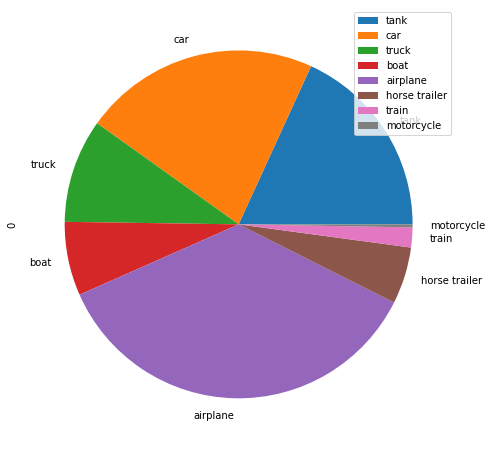

In [ ]:
plot = df_class.plot.pie(subplots=True, figsize=(12,8 ))

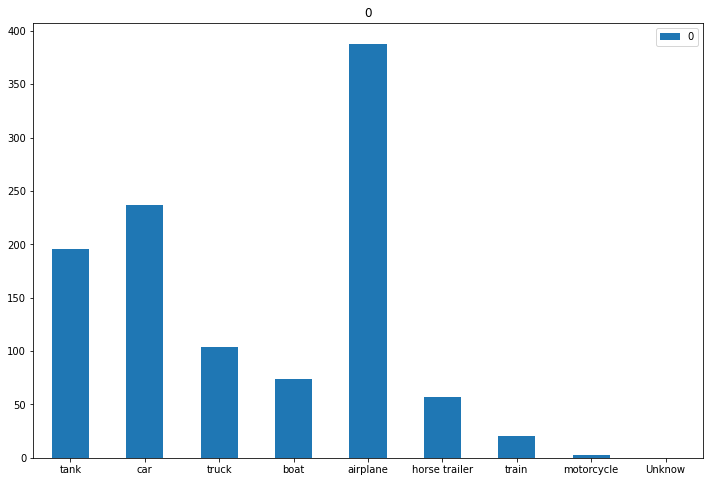

In [ ]:
plot = df_class.plot.bar(subplots=True, figsize=(12,8 ), rot=0)